In [86]:
from pathlib import Path

import json

import pandas as pd
import numpy as np

In [2]:
from ppi_utils.reduce import dedup_pairs
from ppi_utils.pairs import estimate_bias, estimate_bias_per_species
from ppi_utils.api import uniprot_api_fetch
from ppi_utils.extract import ppis_to_hashes
from ppi_utils.general import get_seq_hash, get_ids

## Extract PPIs from the original hu.MAP 2.0

In [3]:
humap_dir = Path.cwd().parent / 'ppi_data/hu.MAP'
assert humap_dir.is_dir()
humap_dir

PosixPath('/home/quirin/PYTHON/ppi/ppi_data/hu.MAP')

There is a train-test-split already!?

In [4]:
humap = list()
for txt in sorted(humap_dir.glob('*.txt')):
    if 'complexes' in txt.stem:
        continue
    tx = pd.read_csv(txt, sep='\t', header=None, names=['ida', 'idb'])
    tx['label'] = 0 if 'neg' in txt.stem else 1
    tx['set_type'] = 'train' if 'train' in txt.stem else 'test'
    humap.append(tx)
humap = pd.concat(humap)

In [5]:
humap.head()

,ida,idb,label,set_type
0,Q99966,Q13393,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9UJY1,Q9H0D2,0,test


In [6]:
h = dedup_pairs(humap.copy())
len(humap), len(humap) - len(h), 'That\'s huuuuuge!'

(3435064, 1417, "That's huuuuuge!")

In [7]:
humap = h
humap.head()

,ida,idb,label,set_type
0,Q13393,Q99966,0,test
1,P78352,Q15648,0,test
2,P42345,Q6WN34,0,test
3,P03891,Q9H0D2,0,test
4,Q9H0D2,Q9UJY1,0,test


In [8]:
humap.set_type.value_counts()
# train-test-split of roughly equal size?!

test     1798599
train    1635048
Name: set_type, dtype: int64

In [9]:
all_ids = dict()
for t in ['train', 'test']:
    h = humap.loc[humap.set_type == t]
    bias = estimate_bias(h)
    ids = set(h.ida) | set(h.idb)
    all_ids[t] = ids
    print(f'{t}:\tn_pairs = {len(h)}\tn_PPIs = {len(h.loc[h.label == 1])}\tbias = {bias[0]:.3f}\tn_uniprot_ids = {len(ids)}')
print(f'shared IDs: {len(all_ids["train"] & all_ids["test"])}')
'Mostly negatives - that\'s kind of good to see'

train:	n_pairs = 1635048	n_PPIs = 7172	bias = -0.228	n_uniprot_ids = 1937
test:	n_pairs = 1798599	n_PPIs = 8329	bias = -0.183	n_uniprot_ids = 2023
shared IDs: 968


"Mostly negatives - that's kind of good to see"

In [10]:
humap.loc[(humap.set_type == 'train')].label.value_counts()

0    1627876
1       7172
Name: label, dtype: int64

In [11]:
uniprot_ids = sorted(all_ids['train'] | all_ids['test'])
len(uniprot_ids), uniprot_ids[:7],

(2992, ['10207', '280964', '3507', '403846', '84311', 'A0AVF1', 'A0JLT2'])

In [12]:
uniprot_ids = [_id for _id in uniprot_ids if not _id.isnumeric()]
len(uniprot_ids), uniprot_ids[:4],

(2987, ['A0AVF1', 'A0JLT2', 'A1A4S6', 'A2A288'])

### Fetch UniProt sequences

In [13]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/humap.fasta'))

jobId: 4ee07964a88e67f84adabd5617549428922f71a9
humap: query + tab ... 2987:0
humap: fasta ...API FASTA: ed018e95a0e1fc4df15b45c24d102ad5543343bca7be8e6b82b8244bdc6c28ac


hash FASTA: 2986it [00:00, 3277.09it/s]
fetch UniParc: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


In [14]:
res

{'A0AVF1': 'CRC-188062024DB89B97',
 'A0JLT2': 'CRC-9B85721364F33F02',
 'A1A4S6': 'CRC-7D7006CEAC0094BD',
 'A2A288': 'CRC-E330D92548D49DD7',
 'A5D8V6': 'CRC-1DE18F0E4C7C7E2E',
 'A5YKK6': 'CRC-937A0899537BA615',
 'A6H687': 'CRC-99C5F943CCD935AE',
 'A6QQ77': 'CRC-A74B5BD9236E4C1E',
 'A7MCY6': 'CRC-C8F42919164A554E',
 'A8K0Z3': 'CRC-DBD5DEAFB7019B3E',
 'A8K8P3': 'CRC-7BE570BDD7F72B6E',
 'A8MT69': 'CRC-0BA47A4F0FFD2978',
 'A8MTZ0': 'CRC-25F2EE32DF0B948D',
 'B3KU38': 'CRC-54C0F2D21E4B2739',
 'F7VJQ1': 'CRC-4360C28341A4CA52',
 'O00116': 'CRC-0E97AE86B513DF32',
 'O00141': 'CRC-F3697C63AB1F499D',
 'O00148': 'CRC-38D02D4234995574',
 'O00159': 'CRC-B105197BA07317B8',
 'O00161': 'CRC-AC378E9786C3A239',
 'O00165': 'CRC-87EEF0C46857704B',
 'O00189': 'CRC-AE3DCA8C5AED08B7',
 'O00203': 'CRC-AC683CE18EF90555',
 'O00206': 'CRC-92C48F55821133E8',
 'O00212': 'CRC-7B960AE8863C6DA5',
 'O00213': 'CRC-FD4A2EF7E8D8E884',
 'O00217': 'CRC-8C3EBD205BFA0112',
 'O00221': 'CRC-45E726E7A0E8D478',
 'O00231': 'CRC-CE11

In [15]:
hash_humap = ppis_to_hashes(humap, Path('uniprot/humap.json'))
hash_humap.head()

,hash_A,hash_B,label,set_type
378407,CRC-000037AE195F7A9D,CRC-0008E21D66E8CFEC,0,test
74220,CRC-000037AE195F7A9D,CRC-000F380D23A9FE8F,0,train
610541,CRC-000037AE195F7A9D,CRC-0026F07D7AB33295,0,test
1084683,CRC-000037AE195F7A9D,CRC-003B3F654F0C60DF,0,test
1772333,CRC-000037AE195F7A9D,CRC-003FABF28F5405D0,0,test


In [16]:
hppis = hash_humap.loc[hash_humap.label == 1]
len(hppis)

15501

In [17]:
hppis.head()

,hash_A,hash_B,label,set_type
1378,CRC-000037AE195F7A9D,CRC-0249E6CA12F77934,1,test
7387,CRC-000037AE195F7A9D,CRC-0860CECC8BF674FE,1,test
1646,CRC-000037AE195F7A9D,CRC-1A73DD35A3501861,1,test
4761,CRC-000037AE195F7A9D,CRC-2023CA8590C7752C,1,train
3868,CRC-000037AE195F7A9D,CRC-26EC965C9239774E,1,test


In [18]:

len(hppis.loc[hppis.set_type == 'train'])

7172

In [19]:
len(hppis.loc[hppis.set_type == 'test'])

8329

In [20]:
ppis = humap.loc[humap.label == 1]
len(ppis)

15501

In [21]:
ppis.head()

,ida,idb,label,set_type
0,Q13616,Q9Y297,1,test
1,O15111,Q676U5,1,test
2,P06213,P35568,1,test
3,P11802,P24385,1,test
4,O00472,Q9HB65,1,test


In [22]:
len(ppis), len(hppis)

(15501, 15501)

### Don't need the hashing!

In [23]:
del hash_humap
del hppis

In [24]:
ppis

,ida,idb,label,set_type
0,Q13616,Q9Y297,1,test
1,O15111,Q676U5,1,test
2,P06213,P35568,1,test
3,P11802,P24385,1,test
4,O00472,Q9HB65,1,test
...,...,...,...,...
7179,O14920,O15111,1,train
7180,Q09028,Q16594,1,train
7181,P61313,P62979,1,train
7182,O15371,O15372,1,train


In [25]:
# look at an example
_id = 'P11802'
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [26]:
ppis.loc[ppis.ida == ppis.idb]
# There's a homodimer!

,ida,idb,label,set_type
3260,P0DMV9,P0DMV9,1,train


## Compare to the hu.MAP set as used by [Burke et al.](https://doi.org/10.1038/s41594-022-00910-8) on their [git](https://gitlab.com/ElofssonLab/huintaf2)

In [27]:
huintaf_dir = Path('/home/quirin/PYTHON/huintaf2')
huintaf = pd.read_csv(huintaf_dir / 'data/humap_pairs.txt', sep=' ', header=None, names=['ida', 'idb'])
len(huintaf)

57128

In [28]:
huintaf.head()

,ida,idb
0,A0A0B4J2A2,A0A075B759
1,A6NI28,A1A4S6
2,A6NJ78,A6NFY7
3,A8MZ97,A6NKD9
4,C9J7I0,A5D8V6


In [29]:
# also no duplicates there
assert len(dedup_pairs(huintaf)) == len(huintaf)

In [30]:
huintaf.loc[(huintaf.ida == _id) | (huintaf.idb == _id)]
# are these predictions? Cause it's sure as heck not the same stuff ...

,ida,idb
4641,P42772,P11802
4643,P42773,P11802
6591,P55273,P11802
10272,Q00534,P11802
16377,Q5TC84,P11802
22713,Q8N726,P11802


## Re-try from OG hu.MAP
Burke et al say they selected the hu.MAP PPIs with a score `> .5`

In [31]:
wumap = pd.read_csv(humap_dir / 'humap2_ppis_ACC_20200821.pairsWprob',
                    sep='\t', header=None, names=['ida', 'idb', 'prob'])
len(wumap)

17526311

In [32]:
wumap.head()

,ida,idb,prob
0,P46926,Q8TDQ7,1.0
1,P43631,Q14954,1.0
2,P43631,Q14953,1.0
3,P43631,P43629,1.0
4,100287045,Q86YD7,1.0


In [33]:
wumap = wumap.loc[wumap.prob >= .5]
len(wumap)
# now that's a relief!

11043

In [34]:
# also drop weird numeric IDs
wumap= wumap.loc[(~wumap.ida.str.isnumeric())
                 & (~wumap.idb.str.isnumeric())]
len(wumap)

10868

In [35]:
len(wumap)

10868

In [36]:
wumap.loc[(wumap.ida == _id) | (wumap.idb == _id)]

,ida,idb,prob
3387,P11802,P42772,0.999704
6202,P11802,Q8N726,0.974196
9725,P11802,P42773,0.654257
9768,P11802,Q5TC84,0.649962


In [37]:
# Again - not the same as extracted from the test split!
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

,ida,idb,label,set_type
3,P11802,P24385,1,test
537,P11802,P30279,1,test
3396,P11802,P38936,1,test
3908,P11802,P30281,1,test
4790,P11802,Q00534,1,test
1068,P11802,P12004,1,train


In [38]:
# verify this is not my mistake some more
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt

P11802	P24385
P11802	P30279
P11802	P38936
P11802	P30281
P11802	Q00534


In [39]:
# a partner with a high annotated interaction p
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P42772"

P11802	P42772	0.999704


In [40]:
# a second partner from the test set
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P30279"

P11802	P30279	3.04045e-07


In [41]:
# search first one in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P42772"

In [42]:
# in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P42772"

In [43]:
# search second in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P30279"

P11802	P30279


In [44]:
# second in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P30279"

# WTF hu.MAP?

ok - still find a match in huintaf!

## start from the end

In [45]:
hua = pd.read_csv(huintaf_dir / 'leo/table_AF2_HURI_HuMap_UNIQUE.csv', sep=',')
len(hua)

65484

In [46]:
hua.head()

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0


In [47]:
hua.Dataset.value_counts()

HURI          55277
HuMap          9898
HuMap;HURI      309
Name: Dataset, dtype: int64

In [157]:
hua.Dataset_max.value_counts()

HURI     55439
HuMap    10045
Name: Dataset_max, dtype: int64

In [51]:
uniprot_ids = get_ids(hua)
len(uniprot_ids)

9932

In [52]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

jobId: befd12c7fe22d86cbafe94756bab95b8d84186e2
...............

KeyboardInterrupt: 

In [53]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

jobId: befd12c7fe22d86cbafe94756bab95b8d84186e2
huintaf: query + tab ... 9934:0
huintaf: fasta ...API FASTA: 12ba75209a53dff49f57eaeb9e0dcd799ed329470da31b1e30a6f0ef627119f0


hash FASTA: 9930it [00:01, 6034.58it/s]
fetch isoforms/archive: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


In [56]:
len(set(res)), len(set(res.values()))

(9932, 9915)

In [57]:
hua

,unique_ID,duplicates,id1,id2,NumRes,IF_plDDT,plDDT,pDockQ,DockQall,PDB,...,structure_file,NumDiso1.90,NumDiso1.70.90,NumDiso1.50.70,NumDiso1.50,NumDiso2.90,NumDiso2.70.90,NumDiso2.50.70,NumDiso2.50,NumOverlap
0,A0A024R0Y4_O14964,1,O14964,A0A024R0Y4,92,67.09186,67.37455,0.077304,NaN,NaN,...,ENSG00000185359-ENSG00000276234.pdb,114.0,253.0,60.0,350.0,72.0,286.0,42.0,43.0,2.0
1,A0A024R0Y4_O15287,1,O15287,A0A024R0Y4,35,68.53878,77.09663,0.038752,NaN,NaN,...,ENSG00000221829-ENSG00000276234.pdb,130.0,339.0,74.0,79.0,41.0,308.0,66.0,28.0,0.0
2,A0A024R0Y4_O60573,1,O60573,A0A024R0Y4,40,59.69327,78.52047,0.034888,NaN,NaN,...,ENSG00000135930-ENSG00000276234.pdb,105.0,58.0,15.0,67.0,118.0,263.0,28.0,34.0,0.0
3,A0A024R0Y4_O75431,1,O75431,A0A024R0Y4,51,76.82288,81.05951,0.075548,NaN,NaN,...,ENSG00000128654-ENSG00000276234.pdb,183.0,56.0,5.0,19.0,42.0,294.0,70.0,37.0,0.0
4,A0A024R0Y4_O75528,1,O75528,A0A024R0Y4,362,90.26991,76.77518,0.730883,NaN,NaN,...,ENSG00000171148-ENSG00000276234.pdb,134.0,119.0,52.0,127.0,180.0,210.0,22.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65479,Q9Y5V3_Q9Y6W3,1,Q9Y6W3,Q9Y5V3,341,57.37788,66.92142,0.142206,NaN,NaN,...,ENSG00000131375-ENSG00000179222.pdb,450.0,289.0,25.0,49.0,68.0,156.0,31.0,523.0,0.0
65480,Q9Y5X5_Q9Y680,1,Q9Y5X5,Q9Y680,154,69.04815,70.20125,0.186659,NaN,NaN,...,ENSG00000056291-ENSG00000079150.pdb,167.0,133.0,19.0,203.0,59.0,110.0,33.0,20.0,0.0
65481,Q9Y5Z9_Q9Y680,1,Q9Y680,Q9Y5Z9,76,68.54175,83.77233,0.069207,NaN,NaN,...,ENSG00000079150-ENSG00000120942.pdb,61.0,116.0,38.0,7.0,233.0,55.0,12.0,38.0,0.0
65482,Q9Y6C2_Q9Y6C2,1,Q9Y6C2,Q9Y6C2,1568,58.37243,55.05549,0.587447,NaN,NaN,...,ENSG00000138080-ENSG00000138080.pdb,7.0,168.0,462.0,379.0,7.0,177.0,437.0,395.0,25.0


## run SETH

In [ ]:
#%env HOME=/mnt/project/kaindl
!bash "huintaf_seth.sh"

In [63]:
with Path('uniprot/huintaf_seth_scores.json').open('r') as json_file:
    seth_scores = json.load(json_file)
_id = next(iter(seth_scores.keys()))
_id, len(seth_scores)

('CRC-148327B7C5E264EF', 9916)

In [64]:
seth_scores[_id].keys()

dict_keys(['seq', 'diso_pred', 'confidence', 'zscores'])

In [102]:
mp = hua[['id1', 'id2', 'pDockQ', 'Dataset_max', ]].copy()
mp.columns = ['ida', 'idb', 'pdockq', 'dataset']
mp.head()

,ida,idb,pdockq,dataset
0,O14964,A0A024R0Y4,0.077304,HURI
1,O15287,A0A024R0Y4,0.038752,HURI
2,O60573,A0A024R0Y4,0.034888,HURI
3,O75431,A0A024R0Y4,0.075548,HURI
4,O75528,A0A024R0Y4,0.730883,HURI


In [103]:
mp['hash_A'] = mp.ida.apply(res.get)
mp['hash_B'] = mp.idb.apply(res.get)

In [104]:
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    mp[f'z{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    mp[f'd{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

mp['zc'] = mp[['za', 'zb']].min(axis=1)
mp['dc'] = mp[['da', 'db']].max(axis=1)

In [105]:
# save
capris = ['incorrect', 'acceptable', 'medium', 'high']
mp['capri'] = mp.pdockq.apply(lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
mp.to_csv('huintaf_scores.tsv', sep='\t', header=True, index=False)
mp.head()

,ida,idb,pdockq,dataset,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HURI,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HURI,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HURI,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HURI,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HURI,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.650670,11.84117,0.388889,0.158014,8.650670,0.388889,medium


In [106]:
len(mp)

65484

In [107]:
# Hi! I'd like to predict secondary structure for about 10K sequences. I know ProtT5 was trained on that -- but how do I make it do that? `sudo prot_t5_xl_uniref50 make sec -i input.fasta` :sweat_smile:

## plot!

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from ppi_utils.general import to_lines
%matplotlib inline

In [109]:
# !mkdir -p plots

In [110]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['legend.frameon'] = False
h = 3  # plot height

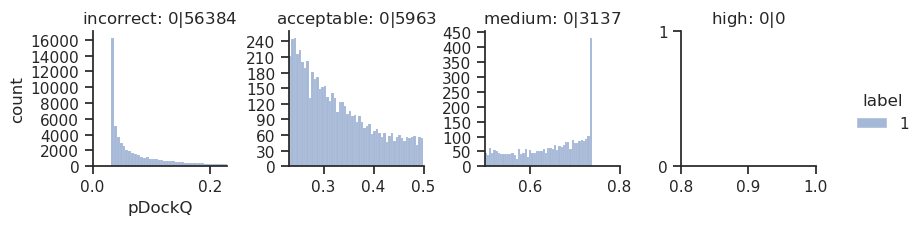

In [111]:
def hists(ddf: pd.DataFrame):
    from matplotlib.ticker import MaxNLocator
    ddf = ddf.copy()
    if 'label' not in ddf.columns:
        ddf['label'] = 1

    sn = sns.displot(data=ddf,
                     x='pdockq',
                     # y='label',
                     hue='label',
                     col='capri', col_order=capris,
                     height=2.4,
                     aspect=.9,
                     # bins=100,
                     facet_kws=dict(sharey=False, sharex=False),
                     # kind='kde',
                     # bw_adjust=.4,
                     )
    # sn.set(xlim=(0, 1), xlabel='',
    #        xticks=[0, .25, .5, .75, 1],
    #        xticklabels=['0', '.25', '.5', '.75', '1'],
    #        )
    # sn.set_titles(col_template='')

    for i, (ax, capri, lim) in enumerate(
            zip(sn.axes.flatten(), capris,
                [(0, .23), (.23, .5), (.5, .8), (.8, 1)])):
        kk = ddf.loc[ddf.capri == capri]
        ax.set(title=f'{capri}: {len(kk.loc[kk.label == 0])}$ | ${len(kk.loc[kk.label == 1])}')
        ax.set(box_aspect=1, xlim=lim)
        ax.set(xlabel='' if i else 'pDockQ')
        ax.set(ylabel='count' if not i else None)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    return sn


sn = hists(mp)
# sn.savefig('plots/capri.pdf')
# sn.savefig('plots/capri.svg')

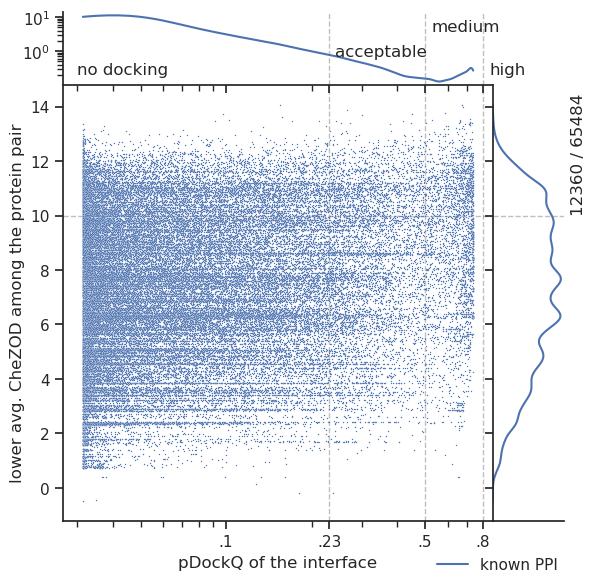

In [132]:
import matplotlib.transforms as transforms

g = sns.JointGrid(data=mp,
                  x='pdockq', y='zc',
                  # hue='label',
                  marginal_ticks=True, height=2 * h,
                  space=0, ratio=6,
                  )
g.plot_joint(sns.scatterplot, legend=False,
             s=1, alpha=1, rasterized=True,
             )
# g.plot_joint(sns.kdeplot, legend=False,
#              # s=25, alpha=.1, rasterized=True,
#              )
# g.plot_joint(sns.histplot,
#              # s=25, alpha=.1, rasterized=True,
#              )
# g.plot_marginals(sns.histplot, multiple='fill')
g.plot_marginals(sns.kdeplot, warn_singular=False,
                 cut=0,
                 # multiple='fill',
                 # bw_adjust=.2,
                 )

g.ax_marg_x.set(xticks=[], yscale='log')
g.ax_marg_y.set(xticks=[])

trans = transforms.blended_transform_factory(
    g.ax_marg_x.transData, g.ax_marg_x.transAxes)
g.ax_marg_x.text(.03, .1, 'no docking',
                 ha='left', va='bottom', transform=trans)
g.ax_marg_x.text(.23 * 1.05, .45, 'acceptable',
                 ha='left', va='center', transform=trans)
g.ax_marg_x.text(.5 * 1.05, .9, 'medium',
                 ha='left', va='top', transform=trans)
g.ax_marg_x.text(.8 * 1.05, .1, 'high',
                 ha='left', va='bottom', transform=trans)

g.ax_joint.set(  # xlim=(ratio - 4, ratio + 4),
    # ylim=(0, 14),
    # xlim=(.23, None),
    ylabel='lower avg. CheZOD among the protein pair',
    xlabel='pDockQ of the interface',
    xscale='log', yscale='linear',
)
g.ax_joint.set(xticks=[.1, .23, .5, .8],
               xticklabels=['.1', '.23', '.5', '.8'])

g.refline(x=.23, lw=1, alpha=.5, zorder=0)
g.refline(x=.5, lw=1, alpha=.5, zorder=0)
g.refline(x=.8, lw=1, alpha=.5, zorder=0)
# g.refline(y=10, lw=1, alpha=.5, zorder=0)

thr = 10
g.refline(y=thr, lw=1, alpha=.5, zorder=0)
ll = len(mp.loc[mp.zc >= thr])
trans = transforms.blended_transform_factory(
    g.ax_marg_y.transAxes, g.ax_marg_y.transData)
g.ax_marg_y.text(1.1, thr, f'{ll} / {len(mp)}',
                 ha='left', va='bottom',
                 rotation=90,
                 transform=trans)

# sns.move_legend(g.ax_joint, loc='lower right', frameon=False,
#                 bbox_to_anchor=(1.2, -.1),
#                 title=None, labels=['known PPI', 'negative'], ncol=1)
g.ax_marg_y.legend(title=None, labels=['known PPI'],
                  bbox_to_anchor=(1.1, -.05), frameon=False)
g.savefig('chezod_huintaf.pdf')

In [133]:
spearmanr(mp.pdockq, mp.zc)

SignificanceResult(statistic=0.17084419285497815, pvalue=0.0)

In [134]:
len(mp)

65484